### Algoritmul K-Nearest Neighbors(kNN) - user-based and item-based collaborative filtering approaches

### Importul bibliotecilor

In [47]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from scipy.sparse import csr_matrix

In [3]:
from recommeders.knn_recommender import Recommender

c:\users\eu\appdata\local\programs\python\python39\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Citirea setului de date

 **[Million Song Dataset](http://millionsongdataset.com/)**
 2 fisiere: 
 song_data.csv - title, rellease,artist name, year
 triplet - userid, songid, listen_count

In [4]:
song_info = pd.read_csv('https://static.turi.com/datasets/millionsong/10000.txt',sep='\t',header=None)
song_info.columns = ['user_id', 'song_id', 'listen_count']

song_actual =  pd.read_csv('https://static.turi.com/datasets/millionsong/song_data.csv')
song_actual.drop_duplicates(['song_id'], inplace=True)

#Unim cele 2 seturi
songs = pd.merge(song_info, song_actual, on="song_id", how="left")

In [5]:
songs.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


Salvam noul set in songs.csv

In [6]:
songs.to_csv('songs.csv', index=False)

Il citim intr-un dataframe df_songs.

In [70]:
df_songs = pd.read_csv('songs.csv')

## Explorarea datelor

In [8]:
df_songs.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [11]:
#Get total observations
print(f"There are {df_songs.shape[0]} observations in the dataset")

There are 2000000 observations in the dataset


In [12]:
df_songs.isnull().sum()

user_id         0
song_id         0
listen_count    0
title           0
release         0
artist_name     0
year            0
dtype: int64

And most of the columns contain strings.

In [13]:
df_songs.dtypes

user_id         object
song_id         object
listen_count     int64
title           object
release         object
artist_name     object
year             int64
dtype: object

- Unique songs:

In [9]:
#Unique songs
unique_songs = df_songs['title'].unique().shape[0]
print(f"There are {unique_songs} unique songs in the dataset")

There are 9567 unique songs in the dataset


- Unique artists:

In [10]:
#Unique artists
unique_artists = df_songs['artist_name'].unique().shape[0]
print(f"There are {unique_artists} unique artists in the dataset")

There are 3375 unique artists in the dataset


- Unique users:

In [11]:
#Unique users
unique_users = df_songs['user_id'].unique().shape[0]
print(f"There are {unique_users} unique users in the dataset")

There are 76353 unique users in the dataset


### Most popular songs

In [12]:
ten_pop_songs = df_songs.groupby('title')['listen_count'].count().reset_index().sort_values(['listen_count', 'title'], ascending = [0,1])
ten_pop_songs['percentage']  = round(ten_pop_songs['listen_count'].div(ten_pop_songs['listen_count'].sum())*100, 2)

In [13]:
ten_pop_songs = ten_pop_songs[:10]
ten_pop_songs

,title,listen_count,percentage
6836,Sehr kosmisch,8277,0.41
8725,Undo,7032,0.35
1964,Dog Days Are Over (Radio Edit),6949,0.35
9496,You're The One,6729,0.34
6498,Revelry,6145,0.31
6825,Secrets,5841,0.29
3437,Horn Concerto No. 4 in E flat K495: II. Romanc...,5385,0.27
2595,Fireflies,4795,0.24
3322,Hey_ Soul Sister,4758,0.24
8494,Tive Sim,4548,0.23


In [14]:
labels = ten_pop_songs['title'].tolist()
counts = ten_pop_songs['listen_count'].tolist()

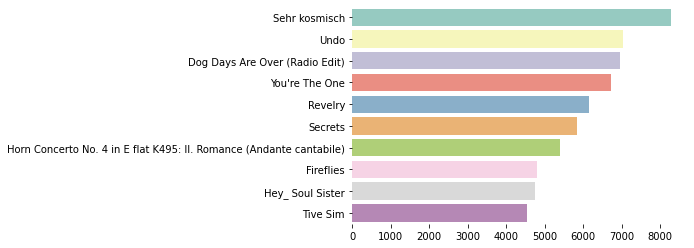

In [15]:
plt.figure()
sns.barplot(x=counts, y=labels, palette='Set3')
sns.despine(left=True, bottom=True)

### Most popular artist

In [16]:

ten_pop_artists  = df_songs.groupby(['artist_name'])['listen_count'].count().reset_index().sort_values(['listen_count', 'artist_name'], 
                                                                                                ascending = [0,1])

In [17]:
ten_pop_artists = ten_pop_artists[:10]
ten_pop_artists

,artist_name,listen_count
649,Coldplay,29422
2850,The Black Keys,19862
1651,Kings Of Leon,18747
1107,Florence + The Machine,18112
1370,Jack Johnson,17801
2946,The Killers,16063
2374,Radiohead,14890
736,Daft Punk,14715
2073,Muse,14005
1554,Justin Bieber,13959


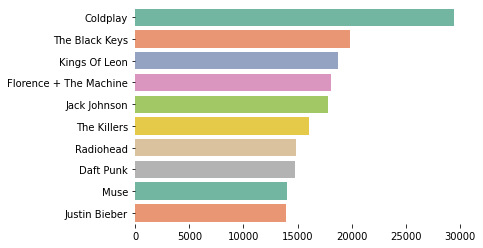

In [18]:
plt.figure()
labels = ten_pop_artists['artist_name'].tolist()
counts = ten_pop_artists['listen_count'].tolist()
sns.barplot(x=counts, y=labels, palette='Set2')
sns.despine(left=True, bottom=True)

### Listen count by user

In [23]:
listen_counts = pd.DataFrame(df_songs.groupby('listen_count').size(), columns=['count'])

In [24]:
print(f"The maximum time the same user listened to the same songs was: {listen_counts.reset_index(drop=False)['listen_count'].iloc[-1]}")

The maximum time the same user listened to the same songs was: 2213


In [25]:
print(f"On average, a user listen to the same song {df_songs['listen_count'].mean()} times")

On average, a user listen to the same song 3.0454845 times


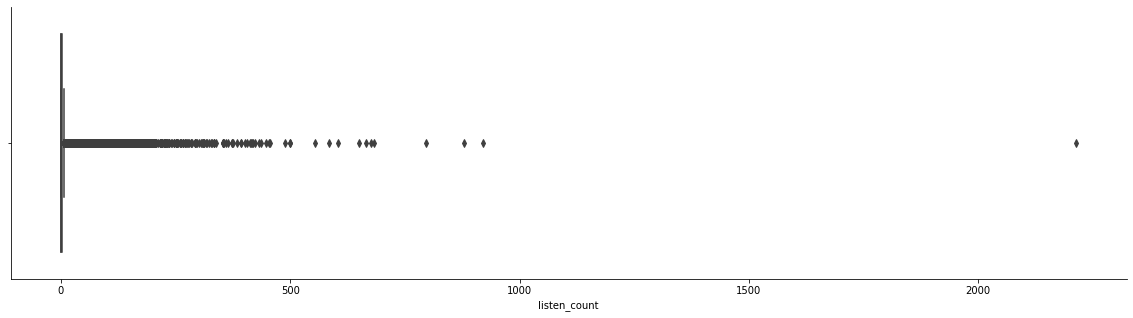

In [26]:
plt.figure(figsize=(20, 5))
sns.boxplot(x='listen_count', data=df_songs)
sns.despine()

**What are the most frequent number of times a user listen to the same song?**

In [27]:
listen_counts_temp = listen_counts[listen_counts['count'] > 50].reset_index(drop=False)

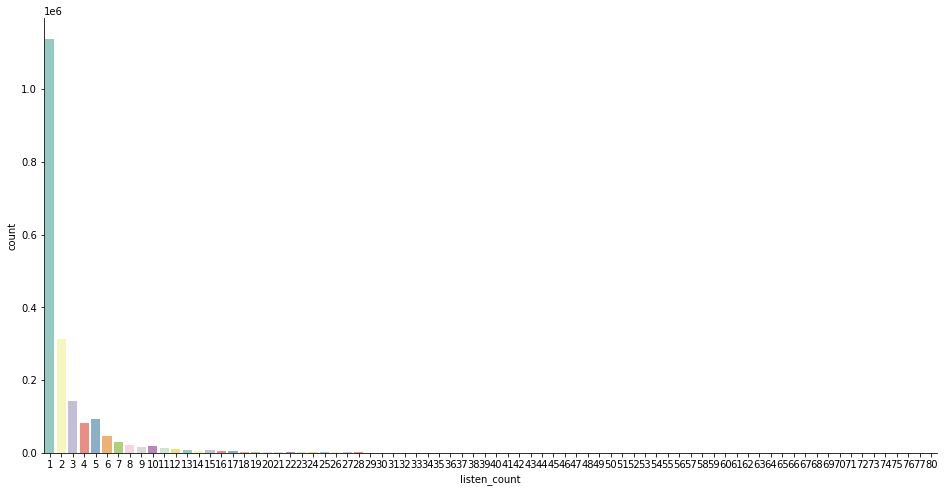

In [28]:
plt.figure(figsize=(16, 8))
sns.barplot(x='listen_count', y='count', palette='Set3', data=listen_counts_temp)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

**How many songs does a user listen in average?**

In [29]:
song_user = df_songs.groupby('user_id')['song_id'].count()

c:\users\eu\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


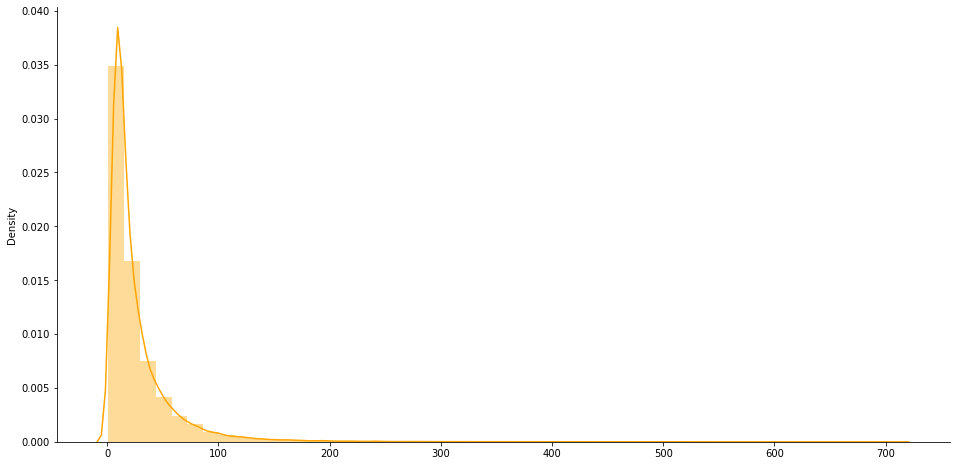

In [30]:
plt.figure(figsize=(16, 8))
sns.distplot(song_user.values, color='orange')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

In [31]:
print(f"A user listens to an average of {np.mean(song_user)} songs")

A user listens to an average of 26.194124657839247 songs


In [33]:
print(f"A user listens to an average of {np.median(song_user)} songs, with minimum {np.min(song_user)} and maximum {np.max(song_user)} songs")

A user listens to an average of 16.0 songs, with minimum 1 and maximum 711 songs


Un utilizator asculta in medie 16 melodii. Maximul de melodii ascultate este 711, si avem 9567 melodii in setul nostru de date.
Deci unele melodii nu sunt ascultate, deci multe valori din matricea song x users vor fi 0. => sparse data

In [34]:
# Get how many values should it be if all songs have been listen by all users
values_matrix = unique_users * unique_songs

In [35]:
# Substract the total values with the actural shape of the DataFrame songs
zero_values_matrix = values_matrix - df_songs.shape[0]

In [36]:
print(f"The matrix of users x songs has {zero_values_matrix} values that are zero")

The matrix of users x songs has 728469151 values that are zero


Data sparse => alegem doar userii care au ascultat mai mult de 16 melodii.

### Pregatim datele

In [37]:
# Get users which have listen to at least 16 songs
song_ten_id = song_user[song_user > 16].index.to_list()

In [38]:
# Filtered the dataset to keep only those users with more than 16 listened
df_song_id_more_ten = df_songs[df_songs['user_id'].isin(song_ten_id)].reset_index(drop=True)

In [73]:
# convert the dataframe into a pivot table
df_songs_features = df_song_id_more_ten.pivot(index='song_id', columns='user_id', values='listen_count').fillna(0)

# obtain a sparse matrix
mat_songs_features = csr_matrix(df_songs_features.values)

<10000x36561 sparse matrix of type '<class 'numpy.float64'>'
	with 1635302 stored elements in Compressed Sparse Row format>

In [40]:
df_songs_features.head()

user_id,000e2c2a8c7870ff9121f212b35c8b3a20cc0e67,000ebc858861aca26bac9b49f650ed424cf882fc,000ef25cc955ad5841c915d269432eea41f4a1a5,0012bf75d43a724f62dc746d9e85ae0088a3a1d6,001322829b5dc3edc59bf78189617ddd8f23c82a,00185e316f07f0f00c325ca034be59c15b362401,0019740e3e8c24e223a6f88e3faa7c144ec5a014,001b005fe5e80d3cb45f320f5658fc8e2e72794e,001f22c638730aed5659034c447d3cf0e658898e,0021d9a4628624f6d70237f9c200ab82e766bf26,...,fff300cd094fe04030b79fae550dc9d065190182,fff4676dacb2e9a7217702f62ee70e88aa512ecc,fff4e1a7dacbe9c13051c08f09bf66d76cbee35e,fff543db7918cb8f4f56f7470903eb2f1d5a6dd8,fff6c30c773e6ffafcac213c9afd9666afaf6d63,fffb701ee87a32eff67eb040ed59146121f01571,fffc0df75a48d823ad5abfaf2a1ee61eb1e3302c,fffce9c1537fbc350ea68823d956eaa8f5236dbe,fffd9635b33f412de8ed02e44e6564e3644cf3c6,fffea3d509760c984e7d40789804c0e5e289cc86
song_id,,,,,,,,,,,,,,,,,,,,,
SOAAAGQ12A8C1420C8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAACPJ12A81C21360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAACSG12AB018DC80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAEJI12AB0188AB5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAFAC12A67ADF7EB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Deoarece se afiseaza id-ul melodiei si nu titlul, facem o functie care mapeaza id cu titlul.
Because the system will output the id of the song, instead of the title, we'll make a function that maps those indices with the song title.

In [71]:
df_unique_songs = df_songs.drop_duplicates(subset=['song_id']).reset_index(drop=True)[['song_id', 'title']]
df_unique_songs

,song_id,title
0,SOAKIMP12A8C130995,The Cove
1,SOBBMDR12A8C13253B,Entre Dos Aguas
2,SOBXHDL12A81C204C0,Stronger
3,SOBYHAJ12A6701BF1D,Constellations
4,SODACBL12A8C13C273,Learn To Fly
...,...,...
9995,SOQYVCY12A8C13AA92,B.O.B.
9996,SORHFLF12A6D4F7429,Sister Seagull
9997,SOXWEPM12AB0181694,Super Honeymoon
9998,SOGYQGZ12AB017E08A,Compañera


In [42]:
decode_id_song = {
    song: i for i, song in 
    enumerate(list(df_unique_songs.set_index('song_id').loc[df_songs_features.index].title))
}

### Modelul si recomandari

Folosim modelul pentru a recomanda melodii.Folosim clasa `Recommender`, metoda `knn_recommender` .

In [57]:
model = Recommender(metric='cosine', algorithm='brute', k=20, data=mat_songs_features, decode_id_song=decode_id_song)

In [68]:
mat_songs_features

<10000x36561 sparse matrix of type '<class 'numpy.float64'>'
	with 1635302 stored elements in Compressed Sparse Row format>

In [65]:
song = 'Just Lose It'

In [66]:
new_recommendations = model.make_recommendation(new_song=song, n_recommendations=10)

Starting the recommendation process for Just Lose It ...
... Done


In [67]:
print(f"The recommendations for {song} are:")
print(f"{new_recommendations}")

The recommendations for Just Lose It are:
['Mockingbird', 'Bagpipes From Baghdad', 'Criminal', 'O Hosanna', 'My Name Is', 'What Can Be Safely Written', 'Crack A Bottle', "The Sky's Ablaze", "Still Don't Give A Fuck", 'The Real Slim Shady']
